## I. Introduction

In this notebook we design simple neural networks from scratch in order to compute European call price. We use the Black & Scholes framework and we use the closed form solution provided by the model as a benchmark for training/evaluating our networks.

We will see that the activation function choice has a big impact on network performance. Sigmoid function does not perform well for deep in the money calls because of its limit. RELU function performs better but lacks of regularity/smoothing and results are still not good enough. Finally, good performance are obtained using ELU functions.

We note that the use of time to maturity as a parameter (instead of time alone) has helped to improve networks performances significantly.

Several tests has shown that a learning rate of 0.01 as well as 4 hidden layers with 20 units in each is optimal.

In [1]:
#%tensorflow_version 1.x
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
tf.__version__

'1.14.0'

## II. Neural Network construction

We assume the learning problem is:
$$\min_{\theta} \left\|\mathcal{NN}_{\theta}\left(X\right)-Y\right\|_2^2$$
where $X\in\mathcal{M}_{n,d}$, $Y\in\mathbb{R}^n$ and $\mathcal{NN}$ is a neural network parametrized by $\theta$.

Below we tested several networks with variations in the number of hidden layers, hidden units per hidden layer and learning rates. Optimal parameters were finally chosen: respectively 4, 20 and 0.01. Several activation functions for the hidden units are tested below. We will keep a one-dimensional output as the price of the call we want to price.

We implement a function `construct_densenn_graph(input_dim, num_hidden_layers, num_hidden_units, learning_rate)` which will construct the graph using tensorflow and return it.

### First network

For this first network we consider sigmoid activation function on all hidden layers and no activation function on the output layer.

In [3]:
def construct_densenn_graph1(input_dim, num_hidden_layers, num_hidden_units, learning_rate):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(tf.float32, shape=(None, input_dim), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
        weights, biases = [], []
        for i in range(num_hidden_layers+1): #construction of the matrix of weights and biaises
            dim_prev = input_dim if i==0 else num_hidden_units
            num_units = 1 if i==num_hidden_layers else num_hidden_units
            weights.append(tf.get_variable('weights/W'+str(i), 
                                            shape=(num_units, dim_prev), 
                                            dtype=tf.float32, 
                                            initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(2/(num_units+dim_prev)))))
            biases.append(tf.get_variable('biases/b'+str(i), shape=(num_units, 1), 
                                            dtype=tf.float32, 
                                            initializer=tf.zeros_initializer()))
        out = tf.transpose(X)
        for i in range(num_hidden_layers+1): #Construction of activation functions
            if i < num_hidden_layers:
                out = tf.nn.sigmoid(tf.matmul(weights[i], out)+biases[i])
            else:
                out = tf.matmul(weights[i], out)+biases[i]
        out = tf.identity(out, name='out')
        loss_fct = tf.reduce_mean((tf.transpose(out) - Y)**2, name='loss_fct')
        gradient_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_fct, var_list=weights+biases, name='gradient_step')
    return g

### Second network

For this second network we consider RELU activation function on all hidden layers and no activation on the output layer.

In [4]:
def construct_densenn_graph2(input_dim, num_hidden_layers, num_hidden_units, learning_rate):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(tf.float32, shape=(None, input_dim), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
        weights, biases = [], []
        for i in range(num_hidden_layers+1): #construction of the matrix of weights and biaises
            dim_prev = input_dim if i==0 else num_hidden_units
            num_units = 1 if i==num_hidden_layers else num_hidden_units
            weights.append(tf.get_variable('weights/W'+str(i), 
                                            shape=(num_units, dim_prev), 
                                            dtype=tf.float32, 
                                            initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(2/(num_units+dim_prev)))))
            biases.append(tf.get_variable('biases/b'+str(i), shape=(num_units, 1), 
                                            dtype=tf.float32, 
                                            initializer=tf.zeros_initializer()))
        out = tf.transpose(X)
        for i in range(num_hidden_layers+1): #Construction of activation functions
            if i < num_hidden_layers:
                out = tf.nn.relu(tf.matmul(weights[i], out)+biases[i])
            else:
                out = tf.matmul(weights[i], out)+biases[i]
        out = tf.identity(out, name='out')
        loss_fct = tf.reduce_mean((tf.transpose(out) - Y)**2, name='loss_fct')
        gradient_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_fct, var_list=weights+biases, name='gradient_step')
    return g

### Third network

For this third network we consider ELU activation function on all hidden layers and no activation on the output layer.

In [5]:
def construct_densenn_graph3(input_dim, num_hidden_layers, num_hidden_units, learning_rate):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(tf.float32, shape=(None, input_dim), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, 1), name='Y')
        weights, biases = [], []
        for i in range(num_hidden_layers+1): #construction of the matrix of weights and biaises
            dim_prev = input_dim if i==0 else num_hidden_units
            num_units = 1 if i==num_hidden_layers else num_hidden_units
            weights.append(tf.get_variable('weights/W'+str(i), 
                                            shape=(num_units, dim_prev), 
                                            dtype=tf.float32, 
                                            initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(2/(num_units+dim_prev)))))
            biases.append(tf.get_variable('biases/b'+str(i), shape=(num_units, 1), 
                                            dtype=tf.float32, 
                                            initializer=tf.zeros_initializer()))
        out = tf.transpose(X)
        for i in range(num_hidden_layers+1): #Construction of activation functions
            if i < num_hidden_layers:
                out = tf.nn.elu(tf.matmul(weights[i], out)+biases[i])
            else:
                out = tf.matmul(weights[i], out)+biases[i]
        out = tf.identity(out, name='out')
        loss_fct = tf.reduce_mean((tf.transpose(out) - Y)**2, name='loss_fct')
        gradient_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_fct, var_list=weights+biases, name='gradient_step')
    return g

### Auxiliary functions

We construct the function `eval_densenn(g, X_in, weights_fitted, biases_fitted)` which, given fitted values of the weights and biases, will evaluate the output value of the dense network corresponding to the input `X` **using TensorFlow**.

In [6]:
def eval_densenn(g, X_in, weights_fitted, biases_fitted):
    X = g.get_tensor_by_name('X:0')
    out = g.get_tensor_by_name('out:0')
    weights = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='weights')
    biases = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='biases')
    feed_dict = {k: v for k, v in zip([X,]+weights+biases, [X_in,]+weights_fitted+biases_fitted)}
    with tf.Session(graph=g) as sess:
        out = sess.run(out, feed_dict=feed_dict)
    return out.T

We now implement a function `fit_densenn_model(g, X_train, Y_train, eps, max_iter)` to train the model.

In [7]:
def fit_densenn_model(g, X_train, Y_train, eps, max_iter):
    X = g.get_tensor_by_name('X:0')
    Y = g.get_tensor_by_name('Y:0')
    gradient_step = g.get_operation_by_name('gradient_step')
    loss_fct = g.get_tensor_by_name('loss_fct:0')
    weights = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='weights')
    biases = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='biases')
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        err = np.inf
        i = 0
        while (err >= eps) and (i < max_iter):
            sess.run(gradient_step, feed_dict={X: X_train, Y: Y_train})
            err = sess.run(loss_fct, feed_dict={X: X_train, Y: Y_train})
            i += 1
        weights_fitted = sess.run(weights)
        biases_fitted = sess.run(biases)
    return weights_fitted, biases_fitted

## III. Testing the networks

We fix the following parameters:
- interest rate r
- volatility sigma
- strike K
- maturity T

We look for the call price given the underlying level at time $t$. So our network will have 2 inputs: $S_t$ and time to maturity $T-t$.

### Call price formula

We implement a function to compute the call price in the Black & Scholes framework.

In [8]:
from scipy.stats import norm

In [9]:
def CallPrice(S, r, sigma, ttm, T, K):
    
    #ttm = T - t
    if ttm < 0:
        return 0.
    elif ttm == 0.:
        return np.maximum(S - K, 0.)

    vol = sigma * np.sqrt(ttm)

    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol

    d_plus = d_minus + vol

    res = S * norm.cdf(d_plus)
    res -= K * np.exp(-r * ttm) * norm.cdf(d_minus)

    return res

We fix the parameters:

In [10]:
r = 0.05
sigma = 0.20
T = 1.0
K = 100.0

Generating the sample to train and test our network:

In [11]:
ttm = T*np.random.sample(size=(100000, 1)) # we evaluate the call at anytime between 0 and the maturity
S = 200*(np.random.sample(size=(100000, 1))) # the underlying can take any value from 0 to 200

In [12]:
X_all = np.array([ttm,S]).T
X_train = X_all[0,:98000, :]
X_valid = X_all[0,98000:99000, :]
X_test = X_all[0,99000:, :]

In [13]:
Y_all = []
for i in range(0,100000):
    Y_all.append(CallPrice(X_all[0,i, 1], r, sigma, X_all[0,i, 0], T, K))

In [14]:
Y_all = np.array([np.array(Y_all)]).T
Y_train = Y_all[:98000, :]
Y_valid = Y_all[98000:99000, :]
Y_test = Y_all[99000:, :]

### Testing the first network

We test the first network with a learning rate of 0.01. We have 4 hidden layers with 20 units in each. Sigmoid on hidden layers and no activation on output layer.

In [15]:
learning_rate_candidates = [0.01] #[0.001,0.01,0.05,0.10,0.5,1.0]
best_valid_err = np.inf
X_mean = X_train.mean(axis=0)
Y_mean = Y_train.mean(axis=0)
for learning_rate in learning_rate_candidates:
    call_nn = construct_densenn_graph1(X_train.shape[1], 4, 20, learning_rate)
    weights_fitted, biases_fitted = fit_densenn_model(call_nn, X_train, Y_train, 1e-8, 1000)
    valid_err = np.mean((eval_densenn(call_nn, X_valid, weights_fitted, biases_fitted) - Y_valid)**2)
    print('Learning rate:',learning_rate,'Validation error', valid_err)
    if valid_err < best_valid_err:
        best_valid_err = valid_err
        best_weights_fitted, best_biases_fitted = weights_fitted, biases_fitted
        best_learning_rate = learning_rate
        best_call_nn = call_nn
print('Best learning rate:',best_learning_rate,'Best validation error', best_valid_err)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Learning rate: 0.01 Validation error 17.70555303159119
Best learning rate: 0.01 Best validation error 17.70555303159119


We now represent on graphs the network results for several valuation times.

In [16]:
ttm = 0.25 # Valuation at time 0.75 year
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [17]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

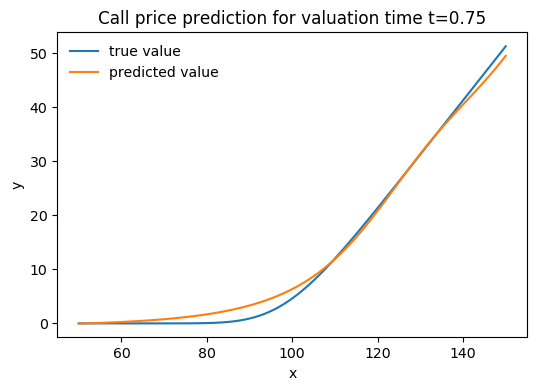

In [18]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.75')
plt.legend(frameon=False);

In [19]:
ttm = 0.99 #Valuation at zero
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [20]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

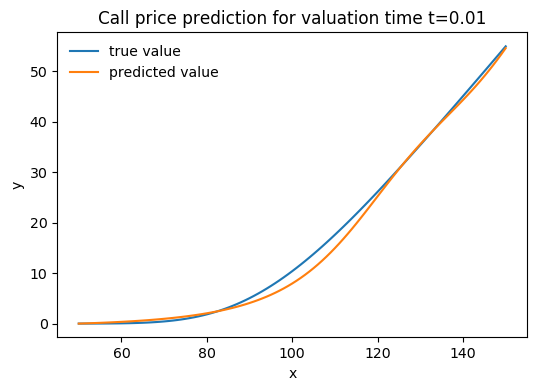

In [21]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.01')
plt.legend(frameon=False);

In [22]:
ttm = 0.01 # Valuation close to maturity
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [23]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

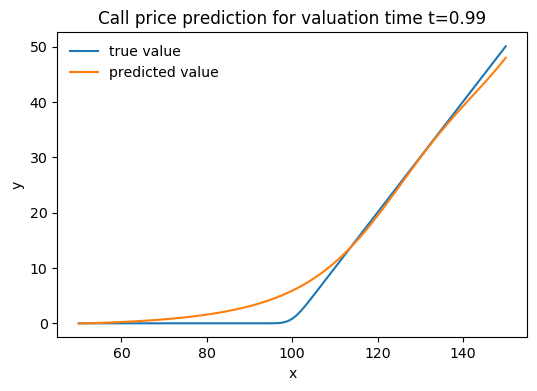

In [24]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.99')
plt.legend(frameon=False);

Below we represent the results of the network on the test sample.

In [25]:
test_y_nn = eval_densenn(best_call_nn, X_test, best_weights_fitted, best_biases_fitted).ravel()
test_err = np.mean((test_y_nn - Y_test[:,0])**2)
print('MSE on test sample:',test_err)

MSE on test sample: 19.159362614399637


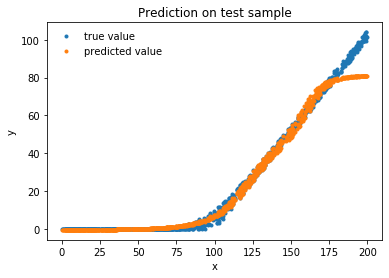

In [26]:
plt.plot(X_test[:,1],Y_test,'.',label='true value')
plt.plot(X_test[:,1],test_y_nn,'.',label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction on test sample')
plt.legend(frameon=False);

We can see that the smooth pattern of the output is well represented in the sigmoid functions, but we still have a large error. Valuating calls close to maturity is difficult with sigmoid only, as the analytical formula is very close to RELU. The test sample shows us that for large values of $S_t$, ie for deep in the money calls, the network is stucked with sigmoid functions limits and cannot reach the call price.

### Testing the second network

We test the second network with a learning rate of 0.01 (still the better). We still have 4 hidden layers with 20 units in each. RELU activation on all hidden layers, excluding output layer.

In [27]:
learning_rate_candidates = [0.01] #[0.001,0.01,0.05,0.10,0.5,1.0]
best_valid_err = np.inf
X_mean = X_train.mean(axis=0)
Y_mean = Y_train.mean(axis=0)
for learning_rate in learning_rate_candidates:
    call_nn = construct_densenn_graph2(X_train.shape[1], 4, 20, learning_rate)
    weights_fitted, biases_fitted = fit_densenn_model(call_nn, X_train, Y_train, 1e-8, 1000)
    valid_err = np.mean((eval_densenn(call_nn, X_valid, weights_fitted, biases_fitted) - Y_valid)**2)
    print('Learning rate:',learning_rate,'Validation error', valid_err)
    if valid_err < best_valid_err:
        best_valid_err = valid_err
        best_weights_fitted, best_biases_fitted = weights_fitted, biases_fitted
        best_learning_rate = learning_rate
        best_call_nn = call_nn
print('Best learning rate:',best_learning_rate,'Best validation error', best_valid_err)

Learning rate: 0.01 Validation error 0.41868136616794904
Best learning rate: 0.01 Best validation error 0.41868136616794904


We now represent on graphs the network results for several valuation times.

In [28]:
ttm = 0.25 # Valuation at time 0.75 year
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [29]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

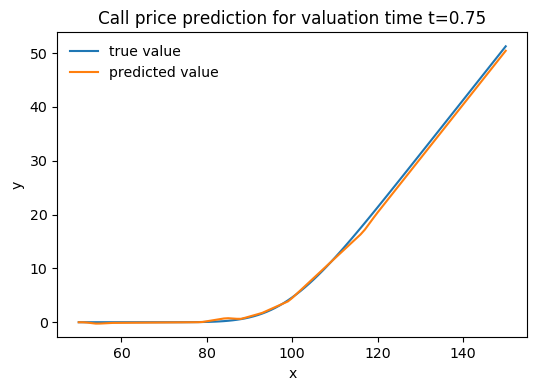

In [30]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.75')
plt.legend(frameon=False);

In [31]:
ttm = 0.99 #Valuation at zero
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [32]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

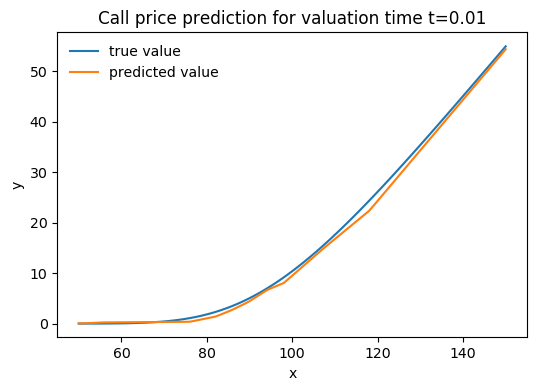

In [33]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.01')
plt.legend(frameon=False);

In [34]:
ttm = 0.01 # Valuation at maturity
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [35]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

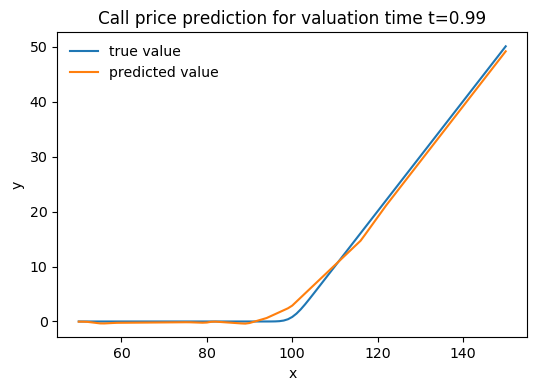

In [36]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.99')
plt.legend(frameon=False);

Below we represent the results of the network on the test sample.

In [37]:
test_y_nn = eval_densenn(best_call_nn, X_test, best_weights_fitted, best_biases_fitted).ravel()
test_err = np.mean((test_y_nn - Y_test[:,0])**2)
print('MSE on test sample:',test_err)

MSE on test sample: 0.42183077737401664


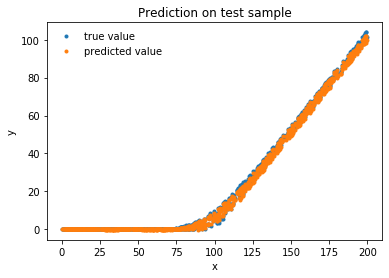

In [38]:
plt.plot(X_test[:,1],Y_test,'.',label='true value')
plt.plot(X_test[:,1],test_y_nn,'.',label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction on test sample')
plt.legend(frameon=False);

We can see here that RELU activation provides better results than sigmoid. However, the price curve is less smooth for calls far from maturity. The gamma increase is better represented for at the money and close to maturity calls.

### Testing the third network

Now that we have seen the sigmoid function cannot be used and that the RELU function is not smooth enough, we test a last network composed of ELU activation functions on hidden layers, that are "a smooth version" of RELU, and no activation function on the output.

4 hidden layers with 20 units in each, learning rate of 0.01. ELU activation function on every hidden layer, no activation function on the output layer.

$ELU(x) = exp(x) - 1\ \text{if x<0},\ x\ \text{otherwise}$

In [51]:
learning_rate_candidates = [0.01] #[0.001,0.01,0.05,0.10,0.5,1.0]
best_valid_err = np.inf
X_mean = X_train.mean(axis=0)
Y_mean = Y_train.mean(axis=0)
for learning_rate in learning_rate_candidates:
    call_nn = construct_densenn_graph3(X_train.shape[1], 4, 20, learning_rate)
    weights_fitted, biases_fitted = fit_densenn_model(call_nn, X_train, Y_train, 1e-8, 1000)
    valid_err = np.mean((eval_densenn(call_nn, X_valid, weights_fitted, biases_fitted) - Y_valid)**2)
    print('Learning rate:',learning_rate,'Validation error', valid_err)
    if valid_err < best_valid_err:
        best_valid_err = valid_err
        best_weights_fitted, best_biases_fitted = weights_fitted, biases_fitted
        best_learning_rate = learning_rate
        best_call_nn = call_nn
print('Best learning rate:',best_learning_rate,'Best validation error', best_valid_err)

Learning rate: 0.01 Validation error 0.31086728994964613
Best learning rate: 0.01 Best validation error 0.31086728994964613


We now represent on graphs the network results for several valuation times.

In [52]:
ttm = 0.25 # Valuation at time 0.75 year
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [53]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

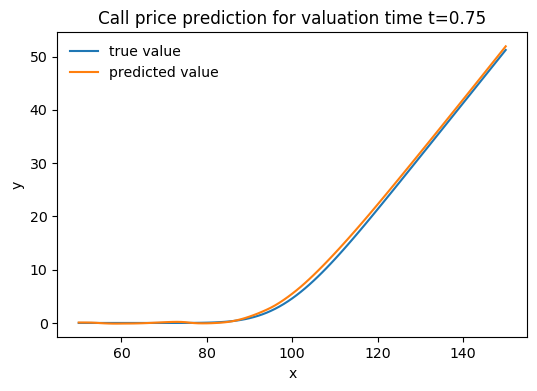

In [54]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.75')
plt.legend(frameon=False);

In [55]:
ttm = 0.99 #Valuation at zero
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [56]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

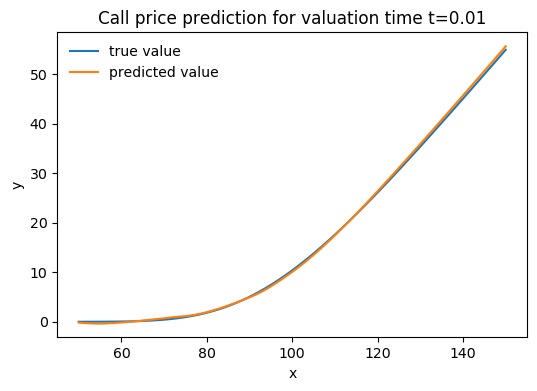

In [57]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.01')
plt.legend(frameon=False);

In [58]:
ttm = 0.01 # Valuation at maturity
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T

In [59]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], r, sigma, _x[i,0], T, K))
true_y = np.array(true_y)

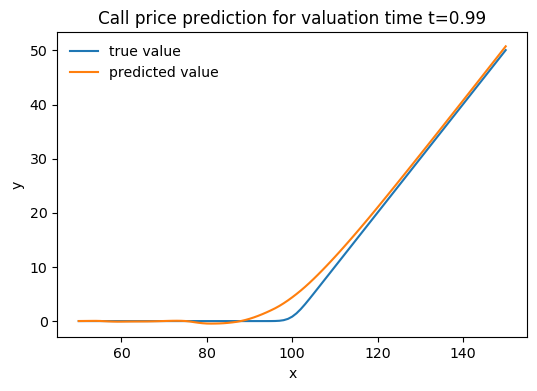

In [60]:
predicted_y_nn = eval_densenn(best_call_nn, _x, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], predicted_y_nn, label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call price prediction for valuation time t=0.99')
plt.legend(frameon=False);

Below we represent the results of the network on the test sample.

In [61]:
test_y_nn = eval_densenn(best_call_nn, X_test, best_weights_fitted, best_biases_fitted).ravel()
test_err = np.mean((test_y_nn - Y_test[:,0])**2)
print('MSE on test sample:',test_err)

MSE on test sample: 0.3254440586918047


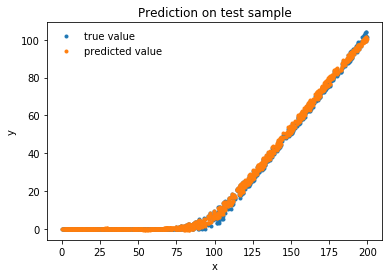

In [62]:
plt.plot(X_test[:,1],Y_test,'.',label='true value')
plt.plot(X_test[:,1],test_y_nn,'.',label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction on test sample')
plt.legend(frameon=False);

We can see that we have improved our results with ELU functions. The smooth character of this function is essential to price calls far from maturity. However, it still has difficulties to price close to maturity and at the money calls, ie when the gamme is the strongest. Compare to other activation function, it has the best results and can replicate call price in almost all situations.

## IV. Opening

We could generate call prices from a more sophisticated model (stochastic volatility and interest rate) and Monte Carlo simulations, then train our networks using more input parameters: time to maturity, spot price, strike, interest rates/volatility process parameters. This would require a bigger and more complex network and a greater computation power.

Usually, prices are not computing directly by neural networks. You can find on another repository an application of neural networks to replicate implied volatility surface from a SABR model. This help to reduce significantly the pricing time when computing complex prices with Monte Carlo techniques (as for exotic derivatives).